# A* Algorithm Using Nodes to Output a Path Between Cities

A* is a greedy search algorithm which uses heuristic estimation to follow the most direct path given that it only looks one step into the future. This tutorial walks through constructing an environment in which A* may be applied, through a mapping example. It then explains the methodology of A*, calculates, and shows, the best route visually. Analysis is provided demonstrating the considerations which should be taken with A*.

### Learning objectives:
    - Inform how A* can be implemented and how it works
    - Discuss situational optimality of A*
    - Displaying geographical maps using geopandas and contextily
    - Configure coordinate systems

### Helpful resources
    - https://xyzservices.readthedocs.io/en/stable/gallery.html
        Available map providers.
    - https://epsg.io/?q=3857
        Reference authority for coordinate systems and similar
    - https://en.wikipedia.org/wiki/A*_search_algorithm
        Low-level description of intricacies of A*
    - https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset
        Common EPSG systems

### Resources used making this tutorial:
    - https://www.youtube.com/watch?v=5G-1k4CNChI
        Usage of Geopandas, Matplotlib, and Contextily libraries to align and superimpose maps to other graphs. Does not discuss A*
    - https://medium.com/@nicholas.w.swift/easy-a-star-pathfinding-7e6689c7f7b2
        A* algorithm basics, with example. Does not explore graph-based A* implementation.
    - https://plainenglish.io/blog/a-algorithm-in-python
        A* algorithm explanation, including graph/node based conceptualisation. Differs by taking a full graph-based approach, with path costs being pre-defined as edges, rather than a dyanamic cost calculation used here.


### The End Goal
This image will be the output from this tutorial. It shows a map retrieved from the internet, with automatically generated roads between cities in blue, and the optimal path shown in green.
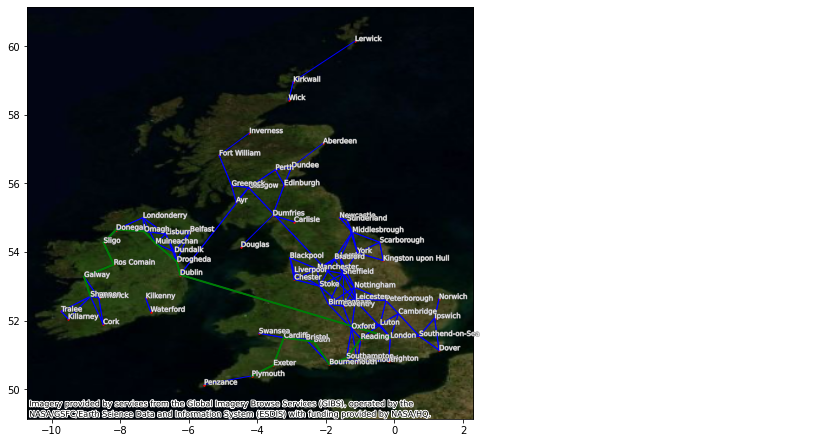

This explanation will follow the code as it is executed, with detail for the purpose of each block, and other ways in which it may be implemented. 
Comments and markdown cells will be used interchangably.

In [1]:
%%capture 
# %%capture can be used to hide output, optionally for display later.
! pip3 install pandas
import pandas as pd
! pip3 install matplotlib
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
import matplotlib

# Geopandas is a version of the pandas library designed to deal with geographical data. 
! pip3 install geopandas
import geopandas as gpd

# Contextily is used for implementing tile maps from the internet. 
# It is designed to integrate with Geopandas, but can be used with matplotlib alone. 
! pip3 install contextily
import contextily as cx

# A* Concepts and Class structure


## Basics of A*
A* minimises the 'cost' to go between two vertices. It needs to be a single value, but may be calculated from many variables. For example, if the cost is the time to drive, it may depend on the distance, the speed limit, road surface, vehicle, and much more. In this example, the cost is the distance. 

In this model, each vertex can only see one vertex ahead.


Defining a Vertex class is an intuitive way to model this information. Each vertex is a city. Higher performance may be found for example through clever usage of data frames. 
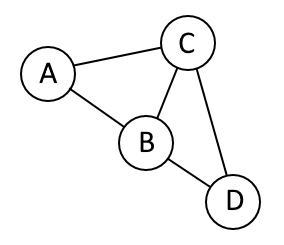

### Finding out which city is 'the best'
##### f =  g  +  h
##### overall_cost = start_to_current + current_to_end_estimate


Take the city with the best overall cost,f.
g should be updated every time a city is visited to update the best known route.


Three key values are needed:
- f - The current estimated overall cost from the start to the end using this route
- g - The best found cost from the start to the current vertex
- h - Heuristic. The best possible cost from the current vertex to the end

### Some key methods and variables are used
One key method is needed:
- get_neighbours. A list of connected cities, defined by the self.adjacency_list. Much of A* looks at the neighbours to find the subsequent next step.

Two lists are needed:
- open_list. A list of cities which have been discovered, and may lead to the best path
- closed_list. A list of cities which are known not to lead to the best path

To generate the example, some additional fields are used:
- latitude / longitude. The geographical position of the city, to define roads and the costs between cities
- size. Used to make roads between capital cities, and make the model slightly more realistic

### Shortest possible pseudocode

Base loops for A* 
- Investigate the city which is best in line between current location and ending location.
- If this city can be reached faster this way than before, use the better path.
- If a city still 'might' be the best, keep it on the open_list
- If a city cannot be the best, take it off the open_list and put it on the closed_list



In [2]:
class Vertex:
    def __init__(self, name="", latitude=0., longitude=0., size=2):
        self.name = name
        self.latitude = float(latitude)
        self.longitude = float(longitude)
        self.adjacency_list = {}
        self.size = size
        self.f = 0
        self.g = 0
        self.h = 0


    def get_neighbours(self):
        return self.adjacency_list.keys()

    # Note: new_path and del_path only act on one 'lane'. 
    # If you make a road from city A to B, there will not be a road from B to A.
    
    def new_path(self, target):
        # Connect two cities together
        self.adjacency_list[target.name] = heuristic(self, target)

    def del_path(self, target):
        # Break a connection between two cities. 
        del self.adjacency_list[target]
        
def new_path(vertex, target, two_way=False):
    # Add a road between two cities
    vertex.new_path(target)
    if two_way:
        target.new_path(vertex)

## Heuristics
The heuristic is the 'general rule' for how far something could be. In this case, the euclidian distance from one place to another is used. 
Rules:
- The heuristic should always underestimate the actual cost. If it does not, A* may settle for a suboptimal route.
- The estimated costs should not change during the search for the best path.


In [3]:
def heuristic(vertex, target):
    dx = target.longitude - vertex.longitude
    dy = target.latitude - vertex.latitude
    h = (dx*dx + dy*dy)**0.5
    return h

### Simple Route
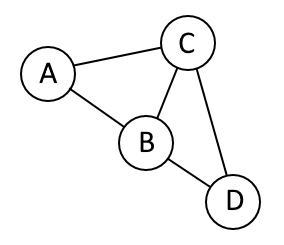

    
1. From A, B is the best line
    - A is opened
    - B and C are opened, A is closed
2. From B, D is the best line
    - B is closed
    - D is opened
3. D is the destination

Route is A-B-D

### Non-obvious Route
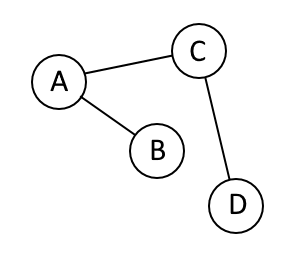
1. From A, B is the best line
    - A is opened
    - B and C are opened. A is closed
2. B has no nodes not already open
    - B is closed
3. From A, C is the best line
4. From C, D is the best line
    - D is opened
    - C is closed
5. D is the destination

Route is A-C-D

### Impossible Route
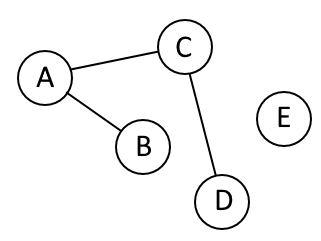
1. From A, B is the best line
    - A is closed
    - B and C are opened
2. B has no connections
    - B is closed
3. From A, C is the best line
4. From C, D is the best line
    - D is opened
    - C is closed
5. D has no connections
    - D is closed
6. No nodes are open. 

There is no route to E

### Better Route Available
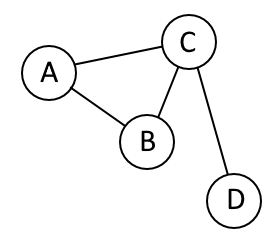
1. From A, B is the best line
    - A is closed
    - B and C are opened
2. From B, C is the best line 
    - B is closed
3. C is already on the open_list
    - C is now better
4. From C, D is the best line
    - C is closed
    - D is opened
5. D is the destination

Route is A-C-D

### Setup

This example saves its cities into a dictionary. As such, referencing cities would be graph[city_name].method

It reads its city data from a .csv file.

In [4]:
graph = {}

# Read in city information from a .csv
with open("Cities.csv", 'r', encoding="utf-8-sig") as f:
    next(f)
    for line in f:
        line = line.split(",")
        if int(line[0]) > -5:
            graph[line[1]] = Vertex(name=line[1],
                                    longitude=float(line[4].strip("\n")),
                                    latitude=float(line[3]),
                                    size=int(line[0]))

# See below for example row input from the data set
# City size, City Name, Country, Latitude, Longitude
print(line)

['1', 'Muineachan', 'Ireland', '54.250000', '-6.966667\n']


### A* Algorithm implementation

In [5]:
def astar(graph, start_pos="Plymouth", end_pos="Tralee"):
    global steps
    steps = 0
    # Resetting data so we can use graph again
    for city in graph:
        graph[city].h = 0
        graph[city].f = 0
        graph[city].g = 0
        
    # Initialising variables. Globals have been used to allow easier partitioning of code for demonstration.
    start = start_pos
    end = end_pos
    global open_list
    global closed_list
    open_list = []
    closed_list = []
    
    # Begin searching from the starting city
    current_node = start
    open_list.append(start)
    
    
    while len(open_list) > 0:
        # While there are cities which do not lead to dead-ends
        
        # Find the open_city which has the lowest overall cost, and investigate it
        # Remove the lowest overall cost from the open_list and add it to the closed list. 
        # This is because we know the best node is either a neighbour of this node, or on a different route entirely.
        current_node = open_list[0]
        current_index = 0
        for index, node in enumerate(open_list):
            steps += 1
            if graph[node].f < graph[current_node].f:
                current_node = node
                current_index = index
        open_list.pop(current_index)
        closed_list.append(current_node)
        
        
        # When A* finds the end, it knows it is the best route and does not need to keep looking for better ones.
        if current_node == end:
            return f"{graph[end].f:.2f}"
        
        # Calculate the new estimated costs (f,g,h) for neighbours of the current node based on what we found at this node.
        for child in graph[current_node].get_neighbours():
            steps +=1
            if child in closed_list:
                #if the child is on the closed_list, we know it is not the best path, and can skip the rest
                continue

            # Save the new costs to temporary locations.
            new_g = graph[current_node].g + (heuristic(graph[child], graph[current_node]))
            new_h = heuristic(graph[child], graph[end])
            new_f = new_g + new_h
            
            if child in open_list:
                # It is a possible good route
                if graph[child].g > new_g:
                    # As the recorded costs are higher than the ones just calculated
                    # The current route is better than the old route, so the costs should be updated
                    graph[child].g = new_g
                    graph[child].h = new_h
                    graph[child].f = new_f

                else:
                    # The old route was better, so the costs should not be updated
                    continue
            else:
                # The child has not been visited before, so the costs should be updated
                graph[child].g = new_g
                graph[child].h = new_h
                graph[child].f = new_f
                open_list.append(child)
    
    # Logically, there are no paths left to investigate
    return False

### Road Setup

In [6]:
# Set up roads for the A* to use. 
# In this case, check each city against each other city for whether they are close to each other, or if both are large.
def make_roads(connect_distance=1, connect_capitals=True):
    for city in graph:
        graph[city].adjacency_list = {} # If running make_roads multiple times, this resets the adjacency list
        for target_city in graph:
            if target_city not in graph[city].adjacency_list:
                if target_city == city:
                    pass
                elif heuristic(graph[city], graph[target_city]) < connect_distance:
                    new_path(graph[city], graph[target_city])
                elif (graph[city].size > 6) and (graph[target_city].size > 6) and connect_capitals:
                    new_path(graph[city], graph[target_city])

    # For cities which have no roads, ensure they each have at least one.
    for city in graph:
        if len(graph[city].adjacency_list.keys()) == 0:
            min = 99999999 # Set the temporary h to an arbitrary high number,
            # it will be progressively decreased as close cities are found.
            closest = "null"
            for target_city in graph:
                if target_city == city:
                    pass
                else:
                    h = heuristic(graph[city], graph[target_city])
                    if h < min:
                        min = h
                        closest = target_city
                    else:
                        pass
            new_path(graph[city], graph[closest])

### Path gathering after computation
There are other ways to generate and display this information. A common solution is that for each node along the path, when it is found, has a self.previous_step assigned, which act as stepping stones between the start and the end.

In [7]:
def print_path(print_console=False):
    #Find the route from the end to the start and return a list

    current_node = end
    path = [end]
    while current_node != start:
        # As the graph is navigated, the f value will decrease as cities get closer to the start
        # Initialise variables
        f = 999
        city = ""

        # Search each city on the path to find the next city along the path
        for neighbour in graph[current_node].get_neighbours():
            if neighbour not in path:
                if neighbour in closed_list:
                    if graph[neighbour].f < f:
                        city = neighbour
                        f = graph[neighbour].f
                        current_node = city
        path.append(city)
    if print_console:
        print(path)
    return path

# User Inputs and A* Outputs
###  Demonstration between Plymouth and Tralee

In [8]:
start, end = "Plymouth", "Tralee"

make_roads(connect_distance=1)
length = astar(graph, start, end)
if length is False:
    print(f"Search took {steps} steps")
else:
    path = print_path()
    print(f"Search took {steps} steps, and route is {length} degrees long")

Search took 559 steps, and route is 17.93 degrees long


# Displaying Maps

In order to display a map, several features have to be controlled.

1. There must be a map image
    - While manual images may be used, many excellent ones exist online, which are already tiled and have coordinate systems. See [Gallery][Gallery].
    - See the code below for an example of implementation
2. The map image must be calibrated to a coordinate system
    - The linked gallery includes coordinate systems in their images.
3. The data which is being put onto the map must have the same coordinate system.
    - This example uses Latitude/Longitude, therefore epsg:4326.
    
    #### Other common systems are:
    - EPSG: 3857. Web Mercator Projection. Commonly used for online mapping, including Google Maps.
    - EPSG: 4326. Latitude/Longitude. Commonly used for GPS systems.
    - [International Terrestrial Reference Frame][ITRF]
    - See [EPSG lookup][CRS]
    

[CRS]: https://epsg.io/
[Gallery]: https://xyzservices.readthedocs.io/en/stable/gallery.html
[ITRF]: https://itrf.ign.fr/en/homepage

In [9]:
# Make a GeoDataFrame from the city data
df = pd.read_csv("Cities.csv", index_col="name")
df_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(
    df.longitude, df.latitude))

In [10]:
def output_map(path="", layer=["all"], size=(10, 10)):   
    path = path
    if "basemap" in layer or "all" in layer: # Used for displaying later in this tutorial
        
        # Set plot extents
        padding = 1
        fig, ax = plt.subplots(figsize=size)
        plt.ylim(df_geo['latitude'].min() - padding, df_geo['latitude'].max() + padding)
        plt.xlim(df_geo['longitude'].min() - padding, df_geo['longitude'].max() + padding)
        
        # Match the GeoDataFrame to the image
        # This is driven by the contextily library
        cx.add_basemap(ax, crs="epsg:4326", source=cx.providers.NASAGIBS.BlueMarble, zoom=5)

    if "roads" in layer or "all" in layer: # Used for displaying later in this tutorial
        # Use Annotate to add a name-tag to every city
        # Use path_effects to give each name-tag a border        
        for city in graph:
            plt.annotate(city, [graph[city].longitude, graph[city].latitude], fontsize=7, color="white",
                         path_effects=[pe.withStroke(linewidth=1, foreground="grey")])
        
        # Draw a line between each connected city
        # Plot accepts as many lines as needed.
        for city in graph:
            for neighbour in graph[city].get_neighbours():
                x1 = graph[neighbour].longitude
                x2 = graph[city].longitude
                y1 = graph[neighbour].latitude
                y2 = graph[city].latitude
                plt.plot([x1, x2], [y1, y2], color="blue", linewidth=1)
                
    if "path" in layer or "all" in layer: # Used for displaying later in this tutorial        
        # Check that there was a path found. 
        # Then add a line between each city on the path
        if type(path) != str:
            for road in range(len(path)-1):
                x1 = graph[path[road]].longitude
                y1 = graph[path[road]].latitude
                x2 = graph[path[road+1]].longitude
                y2 = graph[path[road+1]].latitude
                plt.plot([x1, x2], [y1, y2], color="green", linewidth=2)

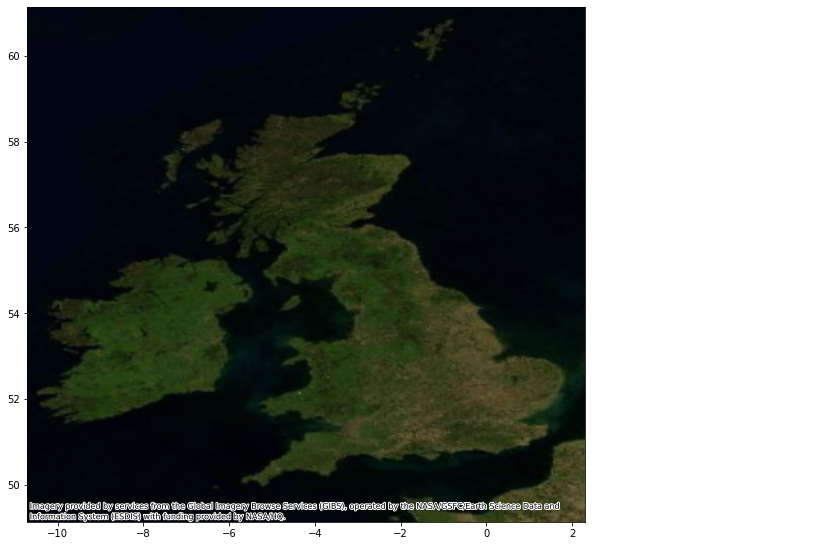

In [11]:
output_map(layer=["basemap"])

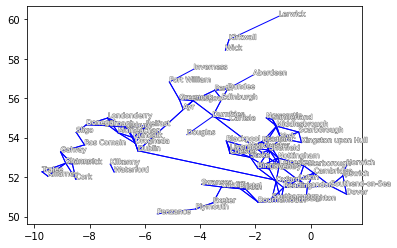

In [12]:
output_map(layer=["roads"])

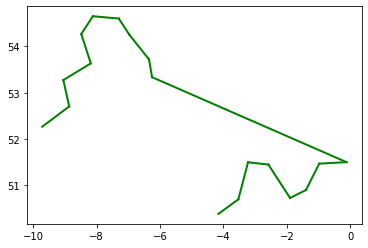

In [13]:
output_map(path=path, layer=["path"])

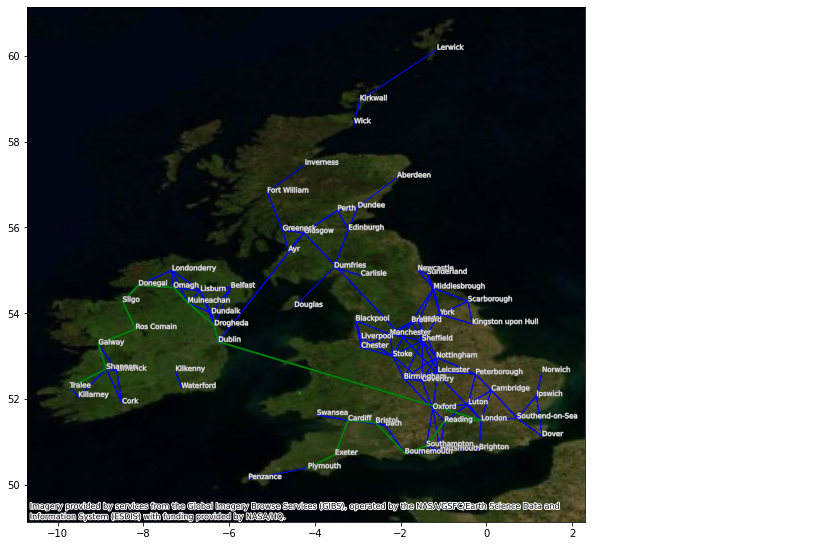

In [14]:
output_map(path=path, layer=["all"])

# Analysis & A* Optimality

This section discusses the efficiency of A* for a variety of types of route, and types of network. A range of connectednesses are tested. 

The above image shows a low connectedness of value 1, where any cities less than one degree away from each other are connected, except for very large cities, which are connected anyway. 
The below image shows high connectedness, of value 2.5.

A degree is one unit of latitude/longitude as per the Geographic Coordinate System.

Search took 554 steps, and route is 10.55 degrees long


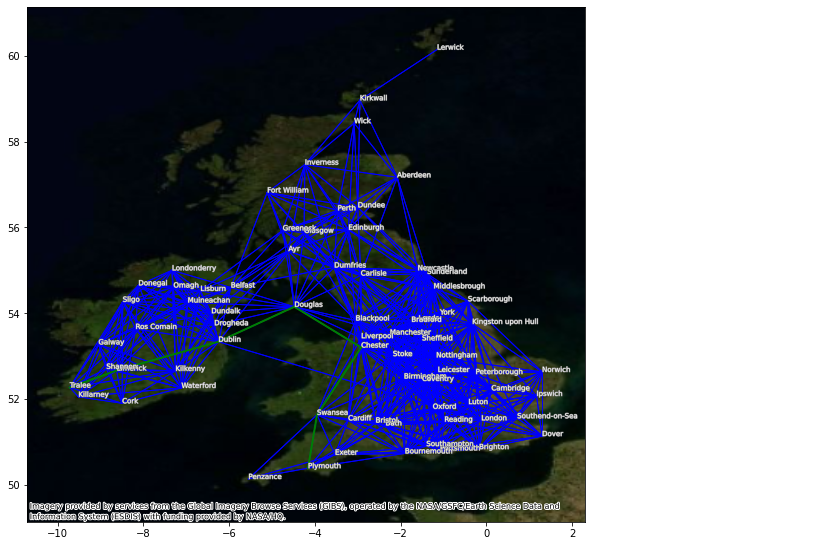

In [15]:
make_roads(connect_distance=2.5)
length = astar(graph)
if length is False:
    print(f"Search took {steps} steps")
    output_map(layer=["basemap", "roads"])
else:
    path = print_path()
    print(f"Search took {steps} steps, and route is {length} degrees long")
    output_map(path=path, layer=["all"])

In [16]:
table = {}
for connect_distance in range(4,18,1):
    make_roads(connect_distance=connect_distance/4, connect_capitals=False)
    length = astar(graph)
    table[connect_distance/4] = (length, steps)
df = pd.DataFrame.from_dict(table, orient='index', columns=['Path Length', 'Calc Steps'])
print(df)

     Path Length  Calc Steps
1.00       False         347
1.25       False         681
1.50       False         978
1.75       11.21         528
2.00       10.66         555
2.25       10.66         649
2.50       10.55         552
2.75        6.65          68
3.00        6.65          74
3.25        6.65          96
3.50        6.10         120
3.75        6.10         133
4.00        6.10         158
4.25        6.10         182


Routings between Plymouth and Tralee. 
This route bridges a waterway, so will normally need to go significantly off path to find a route. 

Path length always decreases with increase in connectivity, as there is higher chance of a route which is less of the straight line from start to end. This route exemplifies that, as path length decreases by almost half at high connectivities.

Calculation steps made every time a city checks another city. Therefore, either high number of cities visited will cause high steps, or high number of connected cities which are being sampled. At worst, both of these factors will multiply. This value is maximal when the number of connections is equal to the number of cities along the path. In the real world, if each node is a road junction with few options, the length of the route will strongly dominate computational steps.

Calculation steps is highest when no path can be found, as the algorithm visits everywhere, and cannot use the optimisation that A* allows. In this case, the steps went very low at medium and high connectivity as the best looking route was consistently the best route, and it was rarely optimal to stray from the greedy path.

Search took 778 steps, and route is 8.44 degrees long


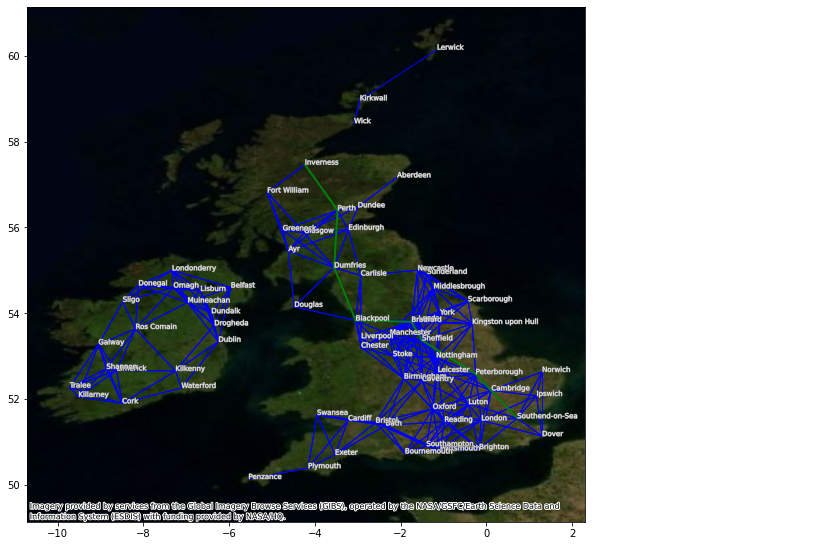

In [17]:
make_roads(connect_distance=1.5, connect_capitals=False)
start, end = "Southend-on-Sea", "Inverness"
length = astar(graph, start_pos=start, end_pos=end)
if length is False:
    print(f"Search took {steps} steps")
    output_map(layer=["basemap", "roads"])
if length is not False:
    path = print_path()
    print(f"Search took {steps} steps, and route is {length} degrees long")
    output_map(path=path, layer=["all"])

In [18]:
table = {}
for connect_distance in range(4,18,1):
    make_roads(connect_distance=connect_distance/4, connect_capitals=False)
    length = astar(graph, start_pos=start, end_pos=end)
    table[connect_distance/4] = (length, steps)
df = pd.DataFrame.from_dict(table, orient='index', columns=['Path Length', 'Calc Steps'])
print(df)

     Path Length  Calc Steps
1.00       False         451
1.25        9.81         758
1.50        8.44         778
1.75        7.92         478
2.00        7.87         536
2.25        7.79         355
2.50        7.79         401
2.75        7.74         324
3.00        7.74         352
3.25        7.74         386
3.50        7.74         331
3.75        7.74         350
4.00        7.74         370
4.25        7.74         394


Routings between Southend-on-Sea and Inverness.
This route is very straight, but bypasses some of the UK's critical sites, incentivising the algorithm to detour slightly. 

Path length does not significantly decrease with increase in connectiveness as the existing route is already reasonably direct. 

Calculation steps of impossible routes are not always high. If there are few connected nodes to explore, A* will rapidly run out of options and exit.

The calculation steps stayed relatively high at all connectivenesses. This is likely due to the number of interconnected cities on the route, which regularly offered greedy, but suboptimal, choices. 